# Predicting Housing Price Index from Economic Indicators
Predicting the price of homes is very important for current homeowners and aspiring homeowners. By accurating assessing the price of homes in future years, current and aspiring homeowners can accurately plan to either own their first home or sell their home at the right time. We have compiled data regarding various economic indicators and are attempting to predict the housing price index [1] using these various indicators. 

##### [1]: The housing price index we are using is the S&P CoreLogic Case-Shiller Housing Price Index, which tracks average price changes in repeat sales or refinancing on properties after weighing properties based on value. Example: If an index value is 100 during one date and 200 during another, it means that housing prices have on average doubled.

For this problem, we are attempting to predict the actual value of the housing price index, which means that our learning problem is a regression problem. For this regression problem, we can try three different models (Random Forest Regression, Gradient Boosting Regression, and Linear Regression) and choose between the models based on which perform better in testing.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from prettytable import PrettyTable

In [2]:
file_path = 'FRED/MORTGAGE30US.csv'
weekly_df = pd.read_csv(file_path, parse_dates=['DATE'])
monthly_data = weekly_df.groupby(pd.Grouper(key='DATE', freq='ME')).mean().reset_index()
monthly_data.to_csv('FRED/monthly_data.csv', index=False)

For our data collection, we collected monthly data on economic indicators from the Federal Reserve Economic Data Database. The dataset we used was created ourselves by combining individual economic features, with research done on what economic factors may impact housing prices. One important feature (Real Gross Domestic Product) only had data points collected seasonally, which meant that instead of 12 data points per year, only 4 data points were collected annually. To work around this and continue to include Real GDP as an important feature, we noticed that Real GDP had very low deviation across adjacent seasons, which led us to duplicate Real GDP values across the 3 months associated with the season. For example, we used the Real GDP value for Spring of 1990 for January, February, and March of 1990. Another feature (Mortgage Average) was collected weekly, which we worked around by aggregating the dataset to only include one value per month by taking the mean of the mortgage collected in the weeks corresponding to a month. Other features were collected monthly but did not necessarily align in their initial collection date. For example, features such as Consumer Price Index collected data all the way from 1957, but our target variable of housing price index only began to be calculated after 1987. This problem was solved by dropping all rows that were not full in our dataframe as columns did not have any blank entries in between the first and last entry, which allowed us to maintain all rows in between the latest first collection date out of the features and the earliest last collection date out of the features.

In [3]:
file_path = 'Monthly_Housing_Price.csv'
df = pd.read_csv(file_path)
df_cleaned = df.dropna()
print(df_cleaned.head())

         DATE  Consumer_Price_Index  Real_Disposable_Income  Real_GDP  \
480  1/1/1987                 111.4                  6494.2  8986.367   
481  2/1/1987                 111.8                  6525.0  8986.367   
482  3/1/1987                 112.2                  6530.5  8986.367   
483  4/1/1987                 112.7                  6282.3  9083.256   
484  5/1/1987                 113.0                  6537.0  9083.256   

     Mortgage_Rate  Population  Unemployment_Rate  Share_Price  \
480         9.2040    241857.0                6.6     14.97068   
481         9.0825    242005.0                6.6     15.86818   
482         9.0350    242166.0                6.6     16.48206   
483         9.8325    242338.0                6.3     16.22884   
484        10.5960    242516.0                6.3     16.14232   

     House_Price_Index  10_Expected_Inflation  House_Supply  
480             63.735               3.524098           6.0  
481             64.135               3.5

In [4]:
X = df_cleaned.drop(columns=['DATE', 'House_Price_Index'])
y = df_cleaned['House_Price_Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
y_test_list = y_test.tolist()

models = [RandomForestRegressor(), GradientBoostingRegressor(), LinearRegression()]
model_names = ['Random Forest', 'Gradient Boosting', 'Linear Regression']

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

y_pred_dict = {}

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_dict[name] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=50)
    scores = cross_val_score(model, X, y, cv=k_fold, scoring='neg_mean_squared_error')
    table = PrettyTable()
    table.add_column("Index", range(1, len(y_pred) + 1))
    table.add_column("y_pred", y_pred)
    table.add_column("y_test", y_test_list)
    print()
    print(f"Model: {name}")
    print("MSE:", mse)
    print("MAE:", mae)
    print("R-squared:", r2)
    print("Score:", score)
    print()
    print("K-Fold Cross-Validation Scores:")
    print("Mean MSE:", -scores.mean())
    print("Standard Deviation MSE:", scores.std())
    print(table)
    print()
    print('---------------------------------------------')


Model: Random Forest
MSE: 3.1288057797022972
MAE: 1.0899513483146057
R-squared: 0.9990605769169436
Score: 0.9990605769169436

K-Fold Cross-Validation Scores:
Mean MSE: 3.5080976732309628
Standard Deviation MSE: 0.9744542012319571
+-------+--------------------+---------+
| Index |       y_pred       |  y_test |
+-------+--------------------+---------+
|   1   | 183.87033000000002 | 183.647 |
|   2   | 204.48753999999983 | 204.696 |
|   3   | 76.71368000000001  |  77.561 |
|   4   | 86.19259999999994  |  86.151 |
|   5   | 166.06622999999996 |  166.63 |
|   6   | 82.93741000000001  |  83.418 |
|   7   | 184.1375400000001  | 184.379 |
|   8   | 164.69561000000004 | 160.129 |
|   9   | 217.59883000000008 | 221.577 |
|   10  | 90.86357999999998  |  91.752 |
|   11  |      81.17904      |  80.691 |
|   12  | 77.03911999999997  |  76.79  |
|   13  | 163.18117999999996 | 166.536 |
|   14  | 144.08362999999986 | 144.705 |
|   15  | 155.85832000000016 | 156.298 |
|   16  |      84.70134      | 

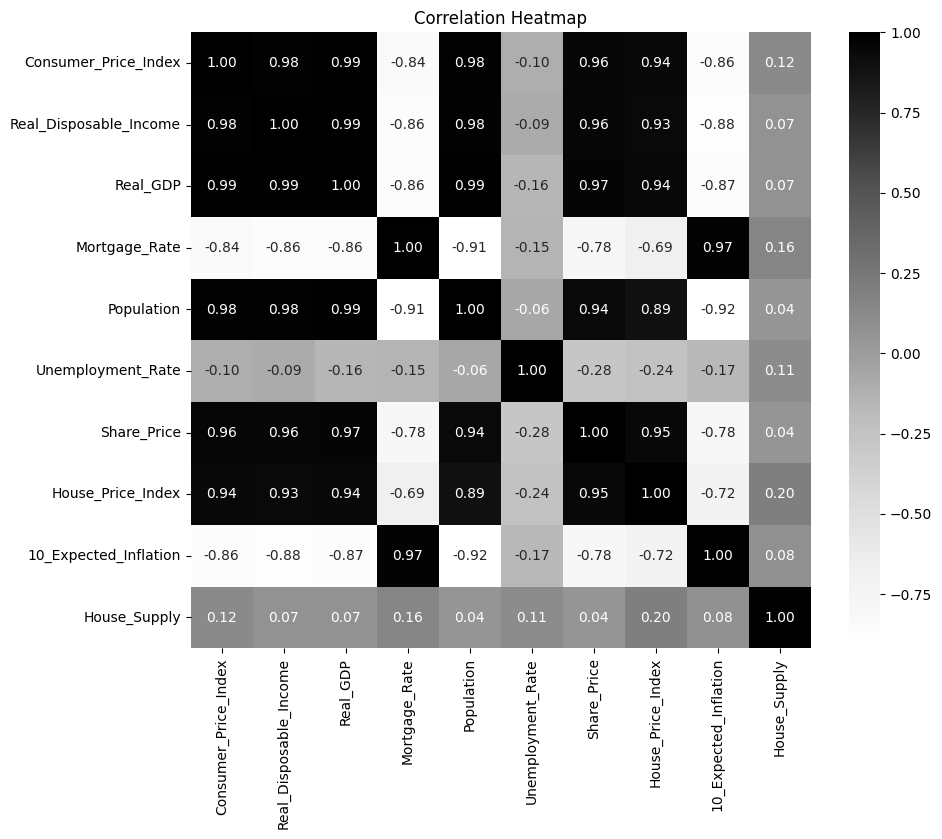

In [6]:
corr_df = df_cleaned.drop(columns=['DATE'])
corr_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Greys', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [7]:
selected_features = ['Consumer_Price_Index', 'Real_Disposable_Income', 'Real_GDP', 'Population', 'Share_Price', '10_Expected_Inflation']
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=50)

In [8]:
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_dict[name] = y_pred
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=50)
    scores = cross_val_score(model, X_selected, y, cv=k_fold, scoring='neg_mean_squared_error')
    table.add_column("Index", range(1, len(y_pred) + 1))
    table.add_column("y_pred", y_pred)
    table.add_column("y_test", y_test_list)
    print()
    print(f"Model: {name}")
    print("MSE:", mse)
    print("MAE:", mae)
    print("R-squared:", r2)
    print("Score:", score)
    print()
    print("K-Fold Cross-Validation Scores:")
    print("Mean MSE:", -scores.mean())
    print("Standard Deviation MSE:", scores.std())
    print(table)
    print()
    print('---------------------------------------------')


Model: Random Forest
MSE: 2.864072082570836
MAE: 0.9469802247191158
R-squared: 0.9991400631373928
Score: 0.9991400631373928

K-Fold Cross-Validation Scores:
Mean MSE: 4.958493016045051
Standard Deviation MSE: 2.2893105139153023
+-------+--------------------+---------+-------+--------------------+---------+
| Index |       y_pred       |  y_test | Index |       y_pred       |  y_test |
+-------+--------------------+---------+-------+--------------------+---------+
|   1   | 163.38954430116326 | 183.647 |   1   | 183.85706000000005 | 183.647 |
|   2   | 214.79588184749173 | 204.696 |   2   | 204.65032999999985 | 204.696 |
|   3   |  85.9188659777476  |  77.561 |   3   | 77.04025000000003  |  77.561 |
|   4   | 86.35829414733894  |  86.151 |   4   | 86.14941999999999  |  86.151 |
|   5   | 171.79288981282093 |  166.63 |   5   | 163.6488999999999  |  166.63 |
|   6   | 81.46042660098385  |  83.418 |   6   | 83.18682000000011  |  83.418 |
|   7   | 162.04500040074242 | 184.379 |   7   | 18

Looking at our 3 models, the Random Forest Regression model seems to perform the best, with the highest r-squared value and score out of the three models. It also has the lowest mean-squared error/mean-absolute error as well as the lowest average mean-squared error in cross-validation.

Through input of features that are more commonly predicted for such as GDP, consumer price index, and others, our model can accurately predict the housing price index. This means that the accuracy of our prediction mostly relies on the accuracy of other predicted values and is close to completely accurate in current data. Being able to predict housing prices in this manner allows us to determine the "right time" to buy and sell houses when faced with possible recessions or other economic events. We can generally predict time periods in which to avoid buying or selling houses as well due to certain indicators changing drastically months before housing prices change as well. 